## ARCH Model Forecasting

**Functions**

`sm.OLS`, `sm.WLS`


### Exercise 54

Use 50% of the sample to estimate your preferred GARCH model for returns to the S&P 500 and the
EUR/USD rate, and construct forecasts for the remaining period.

In [16]:
from arch import arch_model
import pandas as pd
import seaborn as sns
from pandas.plotting import register_matplotlib_converters
import matplotlib.pyplot as plt
import numpy as np
register_matplotlib_converters()

sns.set_style("darkgrid")
plt.rc("figure", figsize=(16, 6))
plt.rc("font", size=14)

In [17]:
sp500 = pd.read_hdf('./data/arch-data.h5','sp500')
# Get the series
sp500 = sp500.SP500
returns = 1000 * sp500.pct_change().dropna()
# TARCH(1,1,1)
mod = arch_model(returns, o=1, power=1.0)
last = returns.index[returns.shape[0] // 2]
res = mod.fit(last_obs=last)
in_samp_variance = res.conditional_volatility ** 2
in_samp_variance.dropna()

forecasts = res.forecast(align="target")
oos_variance = forecasts.variance.dropna()
oos_variance

Iteration:      1,   Func. Count:      7,   Neg. LLF: 4485.018723660958
Iteration:      2,   Func. Count:     18,   Neg. LLF: 4483.412039285513
Iteration:      3,   Func. Count:     27,   Neg. LLF: 4480.082800760504
Iteration:      4,   Func. Count:     35,   Neg. LLF: 4473.414791182588
Iteration:      5,   Func. Count:     42,   Neg. LLF: 4464.584865717883
Iteration:      6,   Func. Count:     51,   Neg. LLF: 4462.456236064096
Iteration:      7,   Func. Count:     60,   Neg. LLF: 4457.657690365339
Iteration:      8,   Func. Count:     67,   Neg. LLF: 4455.751862593274
Iteration:      9,   Func. Count:     75,   Neg. LLF: 4455.480579070787
Iteration:     10,   Func. Count:     82,   Neg. LLF: 4455.4509217002105
Iteration:     11,   Func. Count:     89,   Neg. LLF: 4455.4463589232055
Iteration:     12,   Func. Count:     96,   Neg. LLF: 4455.4462991975615
Iteration:     13,   Func. Count:    103,   Neg. LLF: 4455.446293520799
Optimization terminated successfully.    (Exit mode 0)
      

,h.1
DATE,
2015-01-07,164.597059
2015-01-08,135.068831
2015-01-09,111.715514
2015-01-12,133.144951
2015-01-13,151.692913
...,...
2019-12-24,20.407733
2019-12-26,20.146127
2019-12-27,18.951020


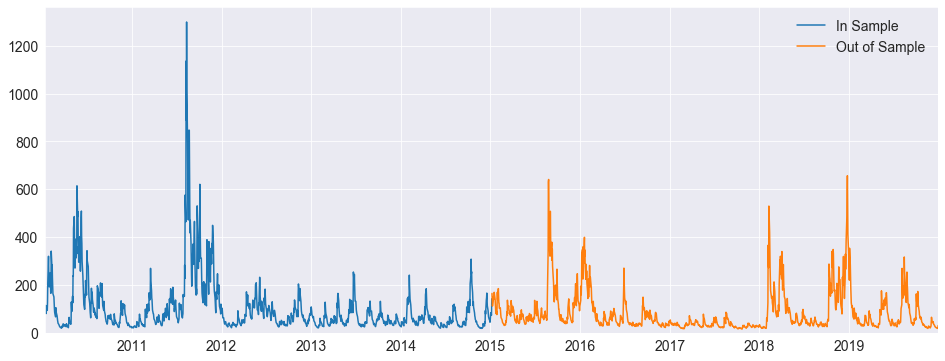

In [18]:
fig, ax = plt.subplots(1, 1)
plt.plot(in_samp_variance, label="In Sample")
plt.plot(oos_variance, label="Out of Sample")
ax.set_xlim(in_samp_variance.index[0], oos_variance.index[-1])
ylim = ax.set_ylim(0, ax.get_ylim()[1])
# The _ is used to capture the output from the legend command so that
# does not print
_ = plt.legend(frameon=False)

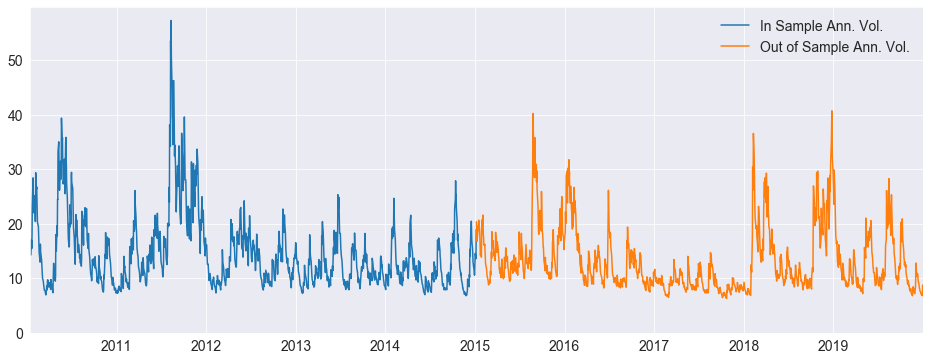

In [19]:
_, ax = plt.subplots(1, 1)
plt.plot(np.sqrt(252*in_samp_variance / 100), label="In Sample Ann. Vol.")
plt.plot(np.sqrt(252*oos_variance / 100), label="Out of Sample Ann. Vol.")
ax.set_xlim(in_samp_variance.index[0], oos_variance.index[-1])
ax.set_ylim(0, ax.get_ylim()[1])
_ = plt.legend(frameon=False)

### Exercise 55

Evaluate the accuracy of the forecasts.

In [20]:
# Join the returns and the variance forecasts
combined = pd.concat([returns, oos_variance], axis = 1)
combined.columns = ["returns","oos_variance"]
# Remove mossing
combined = combined.dropna() 

In [21]:
import statsmodels.api as sm

# Construct the error
variance_error = combined.returns ** 2 - combined.oos_variance
x = sm.add_constant(combined.oos_variance)

res = sm.OLS(variance_error, x).fit(cov_type="HC0")
res.summary()

C:\Anaconda\envs\anaconda-core\lib\site-packages\numpy\core\fromnumeric.py:2495: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.000
Model:                            OLS   Adj. R-squared:                 -0.001
Method:                 Least Squares   F-statistic:                   0.01935
Date:                Fri, 24 Jan 2020   Prob (F-statistic):              0.889
Time:                        18:48:14   Log-Likelihood:                -8085.4
No. Observations:                1255   AIC:                         1.617e+04
Df Residuals:                    1253   BIC:                         1.619e+04
Df Model:                           1                                         
Covariance Type:                  HC0                                         
================================================================================
                   coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------
const           -7.6166     11.505     -0.662      0.508     -30.166      14.933
oos_variance    -0.0236      0.170     -0.139      0.889      -0.356       0.309
==============================================================================
Omnibus:                     1315.863   Durbin-Watson:                   2.013
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            95936.093
Skew:                           4.989   Prob(JB):                         0.00
Kurtosis:                      44.654   Cond. No.                         162.
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity robust (HC0)
"""

In [22]:
test = res.wald_test(np.eye(2), use_f=False)
print(f"Stat: {test.statistic[0,0]}, Pval:{test.pvalue}")

Stat: 7.6644442594595965, Pval:0.02166142760738248


In [23]:
res = sm.WLS(variance_error, x, weights=1./(combined.oos_variance**2)).fit()
res.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            WLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.000
Model:                            WLS   Adj. R-squared:                 -0.001
Method:                 Least Squares   F-statistic:                    0.2708
Date:                Fri, 24 Jan 2020   Prob (F-statistic):              0.603
Time:                        18:48:14   Log-Likelihood:                -7619.3
No. Observations:                1255   AIC:                         1.524e+04
Df Residuals:                    1253   BIC:                         1.525e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
================================================================================
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
const           -5.1903      3.918     -1.325      0.185     -12.876       2.496
oos_variance    -0.0510      0.098     -0.520      0.603      -0.243       0.141
==============================================================================
Omnibus:                     1816.570   Durbin-Watson:                   1.901
Prob(Omnibus):                  0.000   Jarque-Bera (JB):           614752.657
Skew:                           8.235   Prob(JB):                         0.00
Kurtosis:                     110.168   Cond. No.                         77.8
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [24]:
test = res.wald_test(np.eye(2), use_f=False)
print(f"Stat: {test.statistic[0,0]}, Pval:{test.pvalue}")



Stat: 12.109143926359664, Pval:0.0023471065537154284


### Exercise 56

Evaluate the accuracy of forecasts from a 2-year backward moving average variance.

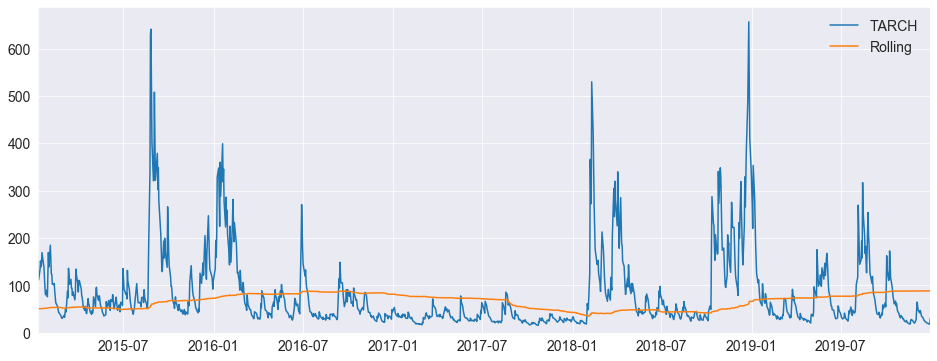

In [25]:
rolling_variance = (returns**2).rolling(2*252).mean()
rolling_variance = rolling_variance.shift(1)
rolling_variance.name = "rolling_variance"
combined = pd.concat([combined, rolling_variance], axis=1).dropna()

_, ax = plt.subplots(1, 1)
plt.plot(combined.oos_variance, label="TARCH")
plt.plot(combined.rolling_variance, label="Rolling")
ax.set_xlim(combined.index[0], combined.index[-1])
ax.set_ylim(0, ax.get_ylim()[1])
_ = plt.legend(frameon=False)

In [26]:
# Construct the error
variance_error = combined.returns ** 2 - combined.rolling_variance
x = sm.add_constant(combined.rolling_variance)

res = sm.OLS(variance_error, x).fit(cov_type="HC0")
res.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.031
Model:                            OLS   Adj. R-squared:                  0.030
Method:                 Least Squares   F-statistic:                     37.76
Date:                Fri, 24 Jan 2020   Prob (F-statistic):           1.07e-09
Time:                        18:48:15   Log-Likelihood:                -8231.6
No. Observations:                1255   AIC:                         1.647e+04
Df Residuals:                    1253   BIC:                         1.648e+04
Df Model:                           1                                         
Covariance Type:                  HC0                                         
====================================================================================
                       coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------
const              134.1073     23.522      5.701      0.000      88.005     180.210
rolling_variance    -1.9418      0.316     -6.145      0.000      -2.561      -1.322
==============================================================================
Omnibus:                     1494.680   Durbin-Watson:                   1.460
Prob(Omnibus):                  0.000   Jarque-Bera (JB):           159696.448
Skew:                           6.091   Prob(JB):                         0.00
Kurtosis:                      56.903   Cond. No.                         298.
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity robust (HC0)
"""

In [27]:
test = res.wald_test(np.eye(2), use_f=False)
print(f"Stat: {test.statistic[0,0]}, Pval:{test.pvalue}")

Stat: 41.163438441822386, Pval:1.1520542072085852e-09


In [28]:
res = sm.WLS(variance_error, x, weights=1./(combined.rolling_variance**2)).fit()
res.summary()


<class 'statsmodels.iolib.summary.Summary'>
"""
                            WLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.024
Model:                            WLS   Adj. R-squared:                  0.024
Method:                 Least Squares   F-statistic:                     31.44
Date:                Fri, 24 Jan 2020   Prob (F-statistic):           2.53e-08
Time:                        18:48:15   Log-Likelihood:                -8452.9
No. Observations:                1255   AIC:                         1.691e+04
Df Residuals:                    1253   BIC:                         1.692e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
====================================================================================
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
const              136.6023     21.360      6.395      0.000      94.697     178.508
rolling_variance    -1.9826      0.354     -5.607      0.000      -2.676      -1.289
==============================================================================
Omnibus:                     1641.605   Durbin-Watson:                   1.446
Prob(Omnibus):                  0.000   Jarque-Bera (JB):           267902.976
Skew:                           7.057   Prob(JB):                         0.00
Kurtosis:                      73.172   Cond. No.                         239.
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [29]:
test = res.wald_test(np.eye(2), use_f=False)
print(f"Stat: {test.statistic[0,0]}, Pval:{test.pvalue}")


Stat: 46.199297869364216, Pval:9.288593000671533e-11


### Exercise 57

Compare the ARCH-model forecasts to a naive 2-year backward looking moving average using QLIKE.

In [30]:
#combined
forecasts = combined[["oos_variance","rolling_variance"]]
ratio = ((combined.returns**2)/forecasts.T).T
qlik = ratio + np.log(forecasts)
delta = qlik.oos_variance - qlik.rolling_variance
lags = int(1.2 * delta.shape[0] ** (1/3))
dm = sm.OLS(delta, np.ones_like(delta)).fit(cov_type="HAC", cov_kwds={"maxlags":lags})
dm.summary()


C:\Anaconda\envs\anaconda-core\lib\site-packages\scipy\stats\_distn_infrastructure.py:901: RuntimeWarning: invalid value encountered in greater
  return (a < x) & (x < b)
C:\Anaconda\envs\anaconda-core\lib\site-packages\scipy\stats\_distn_infrastructure.py:901: RuntimeWarning: invalid value encountered in less
  return (a < x) & (x < b)
C:\Anaconda\envs\anaconda-core\lib\site-packages\scipy\stats\_distn_infrastructure.py:1892: RuntimeWarning: invalid value encountered in less_equal
  cond2 = cond0 & (x <= _a)


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.000
Model:                            OLS   Adj. R-squared:                  0.000
Method:                 Least Squares   F-statistic:                       nan
Date:                Fri, 24 Jan 2020   Prob (F-statistic):                nan
Time:                        18:48:15   Log-Likelihood:                -2808.4
No. Observations:                1255   AIC:                             5619.
Df Residuals:                    1254   BIC:                             5624.
Df Model:                           0                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.4604      0.092     -4.979      0.000      -0.642      -0.279
==============================================================================
Omnibus:                     1786.242   Durbin-Watson:                   1.651
Prob(Omnibus):                  0.000   Jarque-Bera (JB):           579321.112
Skew:                          -7.976   Prob(JB):                         0.00
Kurtosis:                     107.039   Cond. No.                         1.00
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 12 lags and without small sample correction
"""

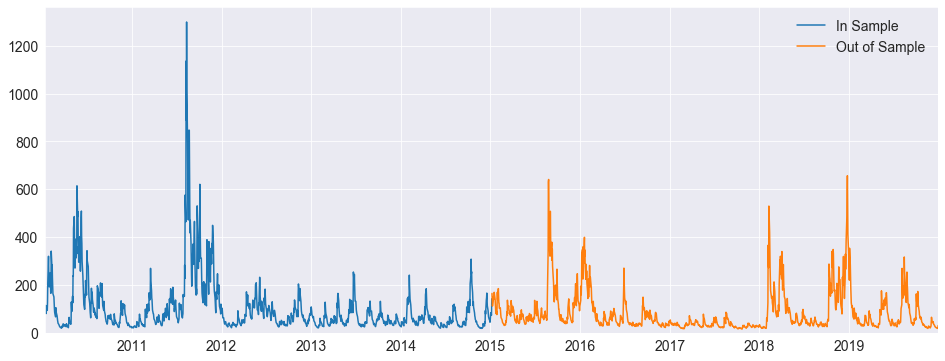

In [31]:
_, ax = plt.subplots(1, 1)
plt.plot(in_samp_variance, label="In Sample")
plt.plot(oos_variance, label="Out of Sample")
ax.set_xlim(in_samp_variance.index[0], oos_variance.index[-1])
ax.set_ylim(0, ax.get_ylim()[1])
legend = plt.legend(frameon=False)

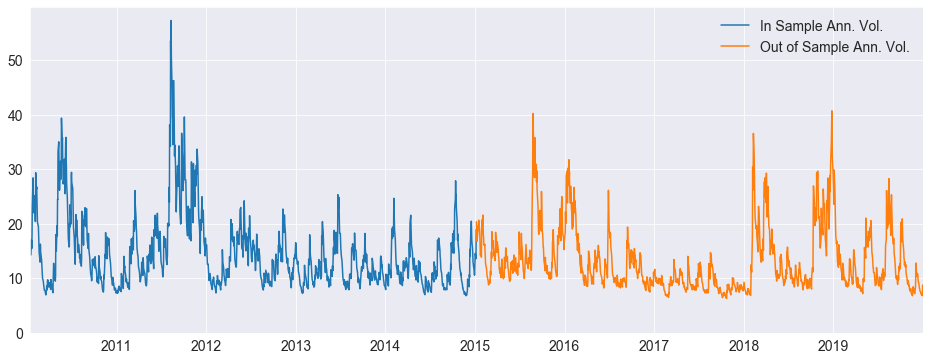

In [32]:
_, ax = plt.subplots(1, 1)
plt.plot(np.sqrt(252*in_samp_variance / 100), label="In Sample Ann. Vol.")
plt.plot(np.sqrt(252*oos_variance / 100), label="Out of Sample Ann. Vol.")
ax.set_xlim(in_samp_variance.index[0], oos_variance.index[-1])
ax.set_ylim(0, ax.get_ylim()[1])
_ = plt.legend(frameon=False)